## How to teach the network?

We already know how the perceptron works, we also know how to combine the perceptrons into a layer and we are also able to create a network of layers with different sizes. Now its time to find out how such a network can be adjusted to fit our needs. Below you can find our current implementation of the neural network. The Layer class is the same class as in the previous chapter, but we now added a Sequential class so we can easily create a network from few layers and use it easier as one object so we dont have to always keep the results from all individual layers of the network.

In [1]:
import numpy as np

class Layer:
    def __init__(self, m_inputs: int, n_perceptrons: int, activation: str = 'relu'):
        self.m = m_inputs
        self.n = n_perceptrons                           
        self.weights_matrix = np.random.rand(self.m, self.n)
        self.biases_vector = np.zeros(self.n)
        self._set_activation(activation)

    
    def _set_activation(self, activation: str):
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        elif activation == 'softmax':
            self.activation = self.softmax
        elif activation == 'tanh':
            self.activation = self.tanh
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x))
        return exp_values / exp_values.sum(axis=0, keepdims=True)

    def tanh(self, x):
        return np.tanh(x)
        
    def forward(self, inputs:list):
        argument = np.dot(self.weights_matrix.T, inputs) + self.biases_vector
        activation = self.activation(argument)
        return activation

In [2]:
class Sequential:
    def __init__(self, layers:list):
        self.layers = layers

    def propagate(self, inputs:list):
        result = None
        for idx, layer in enumerate(self.layers):
            if idx == 0:
                result = layer.forward(inputs)
            else:
                result = layer.forward(result)
        return result

#### Example

In [3]:
x = np.random.rand(8)

neural_network = Sequential([
    Layer(m_inputs=8, n_perceptrons=8, activation="relu"),
    Layer(m_inputs=8, n_perceptrons=16, activation="relu"),
    Layer(m_inputs=16, n_perceptrons=16, activation="relu"),
    Layer(m_inputs=16, n_perceptrons=16, activation="relu"),
    Layer(m_inputs=16, n_perceptrons=8, activation="relu"),
    Layer(m_inputs=8, n_perceptrons=3, activation="tanh")
])

result = neural_network.propagate(x)
print(f"Input X = {x}\nResult = {result}")

Input X = [0.44749142 0.12448628 0.06628307 0.89481918 0.52798017 0.44379338
 0.9522597  0.10656645]
Result = [1. 1. 1.]


#### Backpropagation

Now, let's delve into how to teach the neural network. The first step is to create some kind of metrics for the network's results. When you want to improve at something, you need to assess your results to compare them with the targets you aim to achieve. The same principle applies to neural networks. We need a metric, and this metric is commonly known as the Loss Function.

##### Loss Function (Cost)

There are various cost functions available, and you can find many of them online. For simplicity, let's choose one—either MSE (mean squared error) or CCE (categorical cross entropy). These are defined as follows:

Certainly! Here are the definitions of Mean Squared Error (MSE) and Categorical Cross Entropy (CCE) in LaTeX:

- Mean Squared Error (MSE):

    The mean squared error is calculated as the average of the squared differences between predicted values ($y_i$) and actual values ($t_i$).

    $C_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i^l - t_i^l)^2$

- Categorical Cross Entropy (CCE):

    Categorical Cross Entropy is commonly used in classification problems with multiple classes. Let $y_i$ be the predicted probability for class $i$ and $t_i$ be the true probability for class $i$.

    $C_{CCE} = -\sum_{i=1}^{N} t_i^l \log(y_i^l)$

where $l$ is the layer index and not the power. These formulas provide a measure of how well the neural network's predictions align with the actual targets, which is crucial for training the network effectively.

##### Defining

Let's define some variables for the further calculations:


\begin{align*}
z_j^l &= \sum_{i=1}^{n} w_{ij}^l a_i^{l-1} + b_j^l \\
\sigma(z_j^l) &= a_j^l \\
z_j^{l+1} &= \sum_{i=1}^{n} w_{ij}^{l+1} a_i^l + b_j^{l+1} = \sum_{i=1}^n w_{ij}^{l+1}\sigma(z_i^l)
\end{align*}


##### Chain Rule

We now have defined some terms and we also know how the loss function looks like. The next step is to find out how a small change in a specific weight or bias in the specific perceptron in a specific layer influences the actual loss. This is nothing more than just a simple partial derivative of the loss function with respect to the weight or the bias.


\begin{align*}
\frac{\partial C}{\partial w_{ij}^l} &= \frac{\partial C}{\partial z_{j}^l}\frac{\partial z_j^l}{\partial w_{ij}^l} = \delta_j^l \frac{\partial z_j^l}{\partial w_{ij}^l} \\
\frac{\partial C}{\partial b_{j}^l} &= \frac{\partial C}{\partial z_{j}^l}\frac{\partial z_j^l}{\partial b_{j}^l} = \delta_j^l \frac{\partial z_j^l}{\partial b_{j}^l}
\end{align*}


Let's find out what these terms look like.

- Last layer (L) $\delta_j^L$
    $$
        \delta_j^L = \frac{\partial C}{\partial z_{j}^L} = \frac{\partial C}{\partial a_{j}^L}\frac{\partial a_j^L}{\partial z_{j}^L} \wedge C(a_j^L) = \frac{1}{2}(y_i^L - a_i^L)^2 \Rightarrow    \delta_j^L = (a_j^L - y_j^L)\cdot\sigma^{\prime}(z_j^L)
    $$

- Hidden layers (l) $\delta_j^l$
    $$
        \delta_j^l = \sum_{k = 1}^N \frac{\partial C}{\partial z_{k}^{l+1}}\frac{\partial z_k^{l+1}}{\partial z_{j}^l} = \sum_{k = 1}^N \delta_k^{l+1}\frac{\partial z_k^{l+1}}{\partial z_{j}^l} \wedge \frac{\partial z_k^{l+1}}{\partial z_{j}^l} = \frac{\partial}{\partial z_j^l}\left[ \sum_i^n w_{ik}^{l+1}\sigma(z_i^l) + b_k^{l+1} \right] = \frac{\partial}{\partial z_j^l}\left[ \sum_i^n w_{ik}^{l+1}\sigma(z_i^l) \right] = w_{jk}^{l+1}\sigma^{\prime}(z_j^l)
        \delta_j^l = \sum_{k = 1}^N \delta_k^{l+1} w_{jk}^{l+1}\sigma^{\prime}(z_j^l) \Rightarrow \delta^l = \mathbb{W}^{l+1}\cdot\delta^{l+1}\odot\sigma^{\prime}(z^l)
    $$
    
- $\frac{\partial z_j^l}{\partial w_{ij}^l}$ and $\frac{\partial z_j^l}{\partial b_{j}^l}$

    $$
        \frac{\partial z_j^l}{\partial w_{ij}^l} = \frac{\partial}{\partial w_{ij}^l} \left[ \sum_{i = 1}^n w_{ij}^l a_i^{l-1} \right] = a_i^{l-1} \wedge \frac{\partial z_j^l}{\partial b_{j}^l} = 1
    $$

So we can combine the results from above.


\begin{align*}
\frac{\partial C}{\partial w^l} &= a^{l-1}(\delta^l)^T \\
\frac{\partial C}{\partial b^l} &= \delta^l \\
\delta^l &= \mathbb{W}^{l+1}\cdot\delta^{l+1}\odot\sigma^{\prime}(z^l) \\
\delta^L &= (a^L - y^L)\cdot\sigma^{\prime}(z^L)
\end{align*}


#### Gradient Descent in Neural Network Training

Now that we have discussed the loss function and how to compute the partial derivatives of the loss with respect to the weights and biases through backpropagation, the next step in training a neural network is to optimize these parameters. Gradient Descent is a widely used optimization algorithm that helps adjust the weights and biases to minimize the loss function.

##### Basic Idea

The fundamental idea behind Gradient Descent is to iteratively move towards the minimum of the loss function in the parameter space. It's akin to finding the lowest point in a hilly terrain by adjusting the incline and direction of your steps based on the slope of the hill.

In the context of neural networks, the parameters we want to optimize are the weights $w$ and biases $b$. The iterative update rule for each parameter is given by:

$\text{New Parameter} = \text{Old Parameter} - \text{Learning Rate} \times \text{Gradient of the Loss with respect to the Parameter}$

##### Mathematical Formulation

For a weight $w_{ij}^l$ in layer $l$ and a bias $b_j^l$, the update rules become:

$$
w_{ij}^l = w_{ij}^l - \eta \frac{\partial C}{\partial w_{ij}^l} \\
b_j^l = b_j^l - \eta \frac{\partial C}{\partial b_{j}^l} 
$$

where:
- $\eta$ is the learning rate, a hyperparameter that determines the size of the steps taken during optimization.
- $\frac{\partial C}{\partial w_{ij}^l}$ and $\frac{\partial C}{\partial b_{j}^l}$ are the partial derivatives we computed using the chain rule during backpropagation.

##### Stochastic Gradient Descent (SGD)

In practice, neural networks often use a variant of Gradient Descent called Stochastic Gradient Descent (SGD). Instead of computing the gradient on the entire dataset, SGD randomly selects a small batch of data (mini-batch) at each iteration, which introduces some randomness and can help escape local minima.

##### Implementation Note

The learning rate is a critical hyperparameter. If it's too small, the algorithm may converge very slowly or get stuck in local minima. If it's too large, the algorithm may oscillate or even diverge. Tuning the learning rate is often part of the art of training neural networks.

In LaTeX, the update rule for the weights and biases in a neural network using Gradient Descent can be represented as follows:

$$
w_{ij}^l = w_{ij}^l - \eta \frac{\partial C}{\partial w_{ij}^l} \\
b_j^l = b_j^l - \eta \frac{\partial C}{\partial b_{j}^l}
$$

### Implementation of Backpropagation and Gradient Descent

In [21]:
import numpy as np

class Layer:
    def __init__(self, m_inputs: int, n_perceptrons: int, activation: str = 'relu'):
        self.m = m_inputs
        self.n = n_perceptrons                           
        self.weights_matrix = np.random.rand(self.m, self.n)
        self.biases_vector = np.zeros(self.n)
        self._set_activation(activation)
        self.inputs = None
        self.output = None

    
    def _set_activation(self, activation: str):
        if activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'softmax':
            self.activation = self.softmax
            self.activation_derivative = self.softmax_derivative 
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x))
        return exp_values / exp_values.sum(axis=0, keepdims=True)

    def softmax_derivative(self, x):
        s = self.softmax(x)
        return s * (1 - s)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2
        
    def forward(self, inputs:list):
        self.inputs = inputs
        argument = np.dot(self.weights_matrix.T, inputs) + self.biases_vector
        activation = self.activation(argument)
        self.output = activation
        return activation

    def backward(self, delta, learn_rate):
        # Compute gradients
        dC_dw = np.outer(delta, self.inputs).T
        dC_db = delta
        # Update weights and biases
        self.weights_matrix -= learn_rate * dC_dw
        self.biases_vector -= learn_rate * dC_db
        # Compute and store the delta for the next layer in the network
        delta_next = np.dot(self.weights_matrix, delta) * self.activation_derivative(self.inputs)
        return delta_next

In [113]:
class Sequential:
    def __init__(self, layers:list, cost="cce", tolerance=0):
        self.layers = layers
        self.cost = cost
        self.tolerance = tolerance


    def propagate(self, inputs:list):
        result = None
        for idx, layer in enumerate(self.layers):
            if idx == 0:
                result = layer.forward(inputs)
            else:
                result = layer.forward(result)
        return result

    def predict(self, inputs:list):
        results = []
        for x in inputs:
            results.append(self.propagate(x).flatten())
        return np.array(results)

    def back_propagate(self, y_true, learn_rate):
        # Compute the delta for the output layer
        delta_L = None
        if self.cost == "cce":
            delta_L = self.layers[-1].output - y_true
        elif self.cost == "mse":
            delta_L = (self.layers[-1].output - y_true) * self.layers[-1].activation_derivative(self.layers[-1].output)
        # Backpropagate the delta through the layers
        for layer in reversed(self.layers):
            delta_L = layer.backward(delta_L, learn_rate)

    def cce_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        y_true = y_true.reshape(-1, 1)
        loss = - np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss

    def calculate_accuracy(self, y_true, y_pred):
        if isinstance(y_true, (list, np.ndarray)):
            y_pred_class = np.argmax(y_pred)
            y_true_class = np.argmax(y_true)
            accuracy = 1 if abs(y_true_class - y_pred_class) <= self.tolerance else 0
            return accuracy
        else:
            accuracy = 1 if abs(y_true - y_pred) <= self.tolerance else 0
            return accuracy


    def fit(self, X_train, y_train, epochs, learn_rate):
        for epoch in range(epochs):
            total_loss = 0.0
            total_accuracy = 0.0
            for inputs, target in zip(X_train, y_train):
                # Propagate forward and backward
                output = self.propagate(inputs)
                self.back_propagate(target, learn_rate)
                # Calculate loss and accuracy
                loss = self.cce_loss(target, output)
                accuracy = self.calculate_accuracy(target, output)
                # Sum the total loss and accuracy
                total_loss += loss
                total_accuracy += accuracy
             # Average loss and accuracy over the epoch
            avg_loss = total_loss / len(X_train)
            avg_accuracy = total_accuracy / len(X_train)

            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_accuracy:.4f}")

### Try it Out

#### Create synthetical cathegorical data

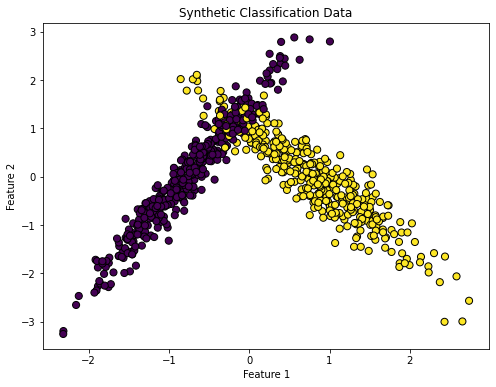

[[-1.15625177e+00 -1.53694576e-01]
 [-3.75241436e-01  5.01498981e-01]
 [-4.41343650e-01  1.15054545e+00]
 [ 6.26007772e-01 -6.03269770e-02]
 [ 3.20327947e-01  5.65407736e-01]
 [-5.25432913e-01  2.93391528e-01]
 [-5.65316287e-01  5.29772640e-01]
 [ 1.22339781e+00 -7.72670939e-02]
 [ 1.30017793e-01  1.71659143e-01]
 [-3.49993281e-01  1.54317033e+00]
 [ 7.60551238e-01 -1.30810222e-01]
 [ 1.62840854e+00 -1.03599004e+00]
 [-1.33250777e+00 -1.27083348e+00]
 [ 2.28464028e+00 -1.59557622e+00]
 [ 3.75646937e-01  4.51727393e-01]
 [-5.61132970e-01  3.66250900e-01]
 [ 1.30950227e+00 -9.18273109e-01]
 [-4.67511972e-01  4.94189212e-01]
 [-8.46041309e-01  2.14805159e-01]
 [ 1.44747683e+00 -1.31805919e+00]
 [-1.81941233e+00 -2.20282214e+00]
 [ 9.84156098e-02  4.62380957e-01]
 [ 1.25179876e+00 -5.32607557e-01]
 [-8.61670242e-01 -3.13519150e-01]
 [ 3.67282651e-01  2.12428651e-01]
 [-1.10757333e+00 -7.15000611e-01]
 [ 8.88610349e-01 -3.85784945e-02]
 [ 7.28558788e-01 -2.87567435e-01]
 [ 8.12237951e-01  2

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to create and plot synthetic classification data
def create_classification_data():
    # Generate synthetic data
    X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                               n_clusters_per_class=1, flip_y=0, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=50)
    plt.title('Synthetic Classification Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

    return X_train, X_test, y_train, y_test

# Create synthetic classification data
X_train, X_test, y_train, y_test = create_classification_data()
print(X_test, y_test)

In [114]:
nn = Sequential([
    Layer(m_inputs=2, n_perceptrons=2, activation="relu"),
    Layer(m_inputs=2, n_perceptrons=6, activation="relu"),
    Layer(m_inputs=6, n_perceptrons=1, activation="sigmoid"),
], cost="cce", tolerance=0.15)

nn.fit(X_train=X_train, y_train=y_train, epochs=100, learn_rate=0.001)

Epoch 1/100 - Loss: 0.2288 - Accuracy: 0.0575
Epoch 11/100 - Loss: 0.3293 - Accuracy: 0.0000
Epoch 21/100 - Loss: 0.2265 - Accuracy: 0.0000
Epoch 31/100 - Loss: 0.1502 - Accuracy: 0.1675
Epoch 41/100 - Loss: 0.1399 - Accuracy: 0.2800
Epoch 51/100 - Loss: 0.1385 - Accuracy: 0.3175
Epoch 61/100 - Loss: 0.1365 - Accuracy: 0.7250
Epoch 71/100 - Loss: 0.1346 - Accuracy: 0.7500
Epoch 81/100 - Loss: 0.1326 - Accuracy: 0.7650
Epoch 91/100 - Loss: 0.1318 - Accuracy: 0.7688


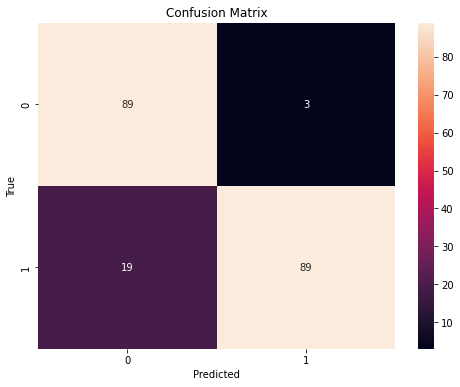

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to convert softmax output to binary predictions
def convert_to_binary(predictions, threshold=0.5):
    return np.where(predictions > threshold, 1, 0)

# Propagate test data
predictions = nn.predict(X_test)

# For binary classification
binary_predictions = convert_to_binary(predictions)

# Create confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()